In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = '/kaggle/input/bank-dataset/playground-series-s4e1'
train = pd.read_csv(f'{DATA_DIR}/train.csv')
train.head(8)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0


In [3]:
train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
test = pd.read_csv(f'{DATA_DIR}/test.csv')
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [5]:
test.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

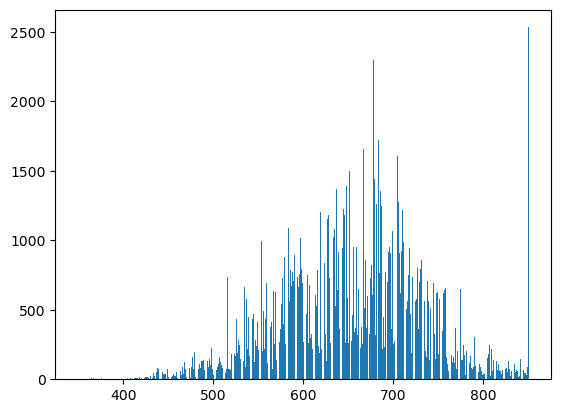

In [6]:
d = train['CreditScore'].value_counts().to_dict()
z = list(zip(*(d.items())))
plt.bar(z[0],z[1])
plt.show()

In [7]:
list(train.columns)

['id',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [6]:
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
multi_categorical_features = ['Geography']
binary_categorical_features = ['Gender']
pass_ordinal_features = ['NumOfProducts']
pass_cardinal_features  = ['HasCrCard', 'IsActiveMember']

## Preprocessing the data

<ol>
    <li>Numeric columns are standardScaled.</li>
    <li>Multi Category columns are one-hot encoded.</li>
    <li>Binary Category columns are Ordinal encoded.</li>
    <li>Others are passed through.</li>
</ol>


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [8]:
numerical_transformer = Pipeline(steps=[
    ('standardScale', StandardScaler()) # Using standard scaling. Shift to zero mean and scale to unit variance
])

binary_categorical_transformer = Pipeline(steps=[
    ('ordinalEncode', OrdinalEncoder()) # Using ordinal encoder even for categorical here since only 2 classes(binary)
])

multi_categorical_transformer = Pipeline(steps=[
    ('onehotEncode', OneHotEncoder(sparse_output=False)) # Allowing dense representation(i.e. zeros are present too)
])

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bincat', binary_categorical_transformer, binary_categorical_features),
        ('multicat', multi_categorical_transformer, multi_categorical_features),
        ('pass', 'passthrough', pass_ordinal_features+pass_cardinal_features),
    ]
)

In [10]:
X_train = preprocessor.fit_transform(train) #output of the transformation is numpy
X_test = preprocessor.transform(test) #output of the transformation is numpy

In [13]:
X_train.shape, X_test.shape

((165034, 12), (110023, 12))

### Visualize the data in 2D using PCA

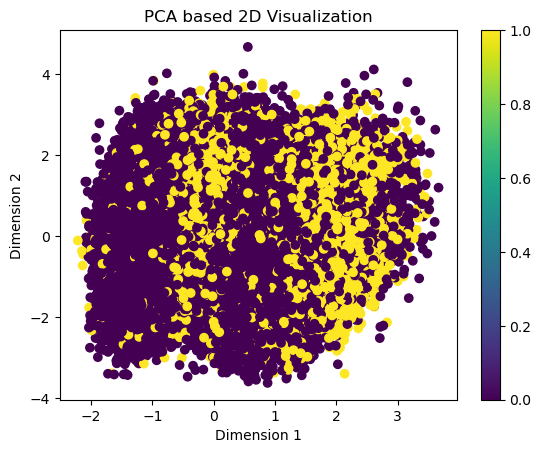

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

# Plotting the results
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train['Exited'], cmap='viridis')
plt.colorbar()
plt.title('PCA based 2D Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Use Logistic Regression to classify the data

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [16]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, train['Exited'])
y_pred_proba = model.predict_proba(X_train)
y_pred = model.predict(X_train)

In [17]:
acc = np.sum(y_pred==train['Exited'])/X_train.shape[0]
loss = log_loss(train['Exited'], y_pred_proba)
print(f'Training Loss -- {loss}, Training Accuracy -- {acc}')

Training Loss -- 0.395476453045244, Training Accuracy -- 0.8341675048777828


In [30]:
y_pred_proba[0], y_pred[0], train.iloc[5]['Exited']

(array([0.91586009, 0.08413991]), 0, 1)

In [18]:
y_test_proba = model.predict_proba(X_test)

In [21]:
y_test_proba[0]

array([0.97630906, 0.02369094])

In [36]:
out_dframe = pd.DataFrame({'id':test['id'], 'Exited':y_test_proba[:,1]})
out_dframe.set_index('id', inplace=True)
out_dframe.head()

,Exited
id,
165034,0.023691
165035,0.578735
165036,0.152151
165037,0.206846
165038,0.422926


In [37]:
out_dframe.to_csv('./output/logistic.csv')

The Logistic Regression output produces a ROC-AUC score of 0.81919 

### Use SVC to classify the data

SVC -- Support Vector Classification is a classification algorithm that is based on SVM(Support Vector Machine)

In [38]:
from sklearn.svm import SVC

SVC with Linear Kernel

In [40]:
model = SVC(kernel='linear', probability=True) # Linear Kernel
model.fit(X_train, train['Exited'])
y_pred_proba = model.predict_proba(X_train)

In [45]:
y_test_proba = model.predict_proba(X_test)

In [47]:
out_dframe = pd.DataFrame({'id':test['id'], 'Exited': y_test_proba[:,1]})
out_dframe.set_index('id', inplace=True)
out_dframe.head()

,Exited
id,
165034,0.025257
165035,0.607031
165036,0.150804
165037,0.243091
165038,0.439524


In [48]:
out_dframe.to_csv('./output/linearSVC.csv')

The Linear SVC output produces a ROC-AUC score of 0.81736

Testing on Polynomial Kernel and RBF Kernel. Arguments in the actual file. Ran both of them simultaneously as multiprocess. So, code in SVC_kernel_fit.py 

In [25]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [23]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, min_accuracy):
        super(CustomEarlyStopping, self).__init__()
        self.min_accuracy = min_accuracy
    
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        if accuracy > self.min_accuracy:
            print(f"Accuracy - {accuracy} exceeds Min Accuracy - {self.min_accuracy}. Stopping Training ")
            self.model.stop_training = True


In [26]:
custom_early_stopping = CustomEarlyStopping(min_accuracy=0.99)
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((X_train, train['Exited']))
dataset = dataset.batch(batch_size)
history = model.fit(dataset, epochs=100, callbacks=[custom_early_stopping])

Epoch 1/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8441 - loss: 0.3677
Epoch 2/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8632 - loss: 0.3297
Epoch 3/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8636 - loss: 0.3273
Epoch 4/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8645 - loss: 0.3262
Epoch 5/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8642 - loss: 0.3255
Epoch 6/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8648 - loss: 0.3248
Epoch 7/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8651 - loss: 0.3242
Epoch 8/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8655 - loss: 0.3238
Epoch 9/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8658 - loss: 0.3231
Epoch 10/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8650 - loss: 0.3233
Epoch 11/100
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8661 - loss: 0.3226
Epoch 12/100
2579/

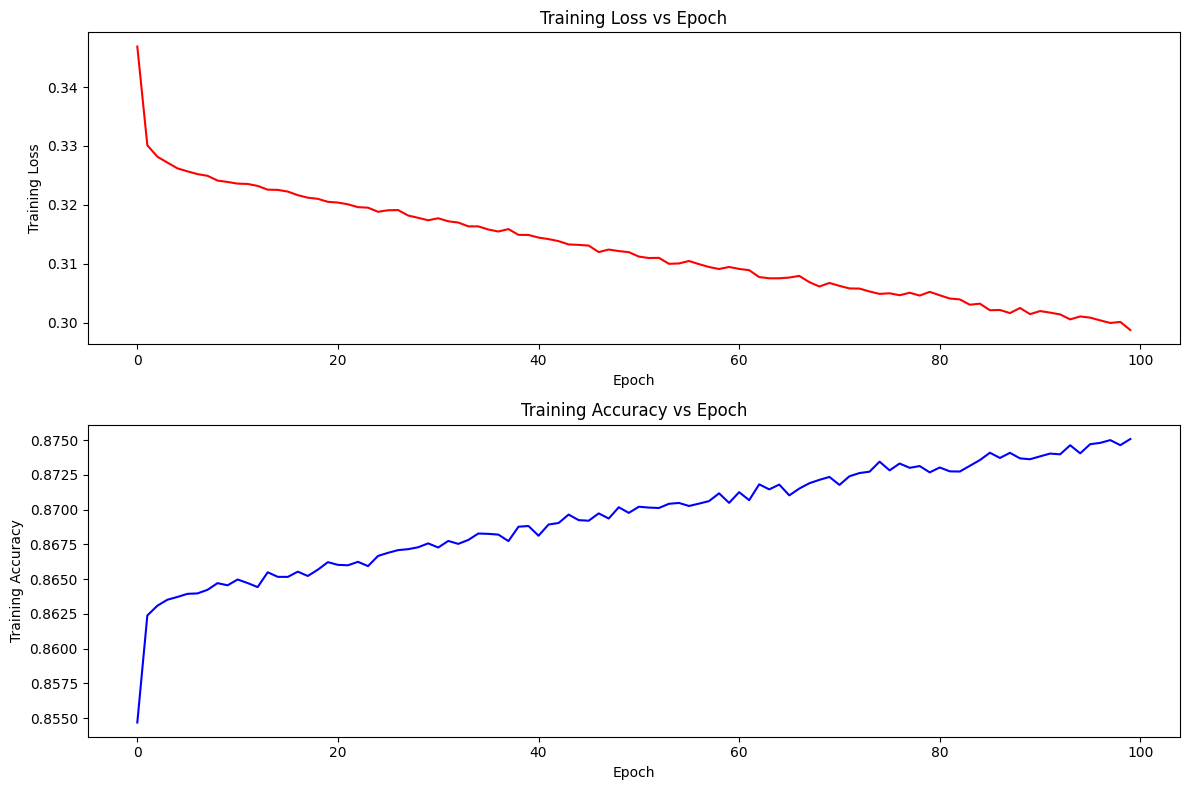

In [34]:
fig, axis = plt.subplots(2,1,figsize=(12, 8))

axis[0].plot(history.epoch, history.history['loss'], color='red')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Training Loss')
axis[0].set_title('Training Loss vs Epoch')

axis[1].plot(history.epoch, history.history['accuracy'], color='blue')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Training Accuracy')
axis[1].set_title('Training Accuracy vs Epoch')

plt.tight_layout()
plt.show()


In [38]:
out_dframe = pd.DataFrame({'id':test['id'], 'Exited': y_test_prob[:,0]})
out_dframe.set_index('id', inplace=True)
out_dframe.head()

,Exited
id,
165034,0.042327
165035,0.841125
165036,0.026104
165037,0.201483
165038,0.352994


In [39]:
out_dframe.to_csv('/kaggle/working/deepNeural.csv')

The Deep Neural Network output produces a ROC-AUC score of 0.87101